In [73]:
%matplotlib inline

import os
from glob import glob
import datacleaner
reload(datacleaner)
import matplotlib.pyplot as plt
from datacleaner import LightCurve, generate_fiducial_model_lc_short
import numpy as np
import matplotlib.gridspec as gridspec

long_lc = LightCurve.from_dir('../lightcurves/raw_long')

# Chunking by stellar rotation

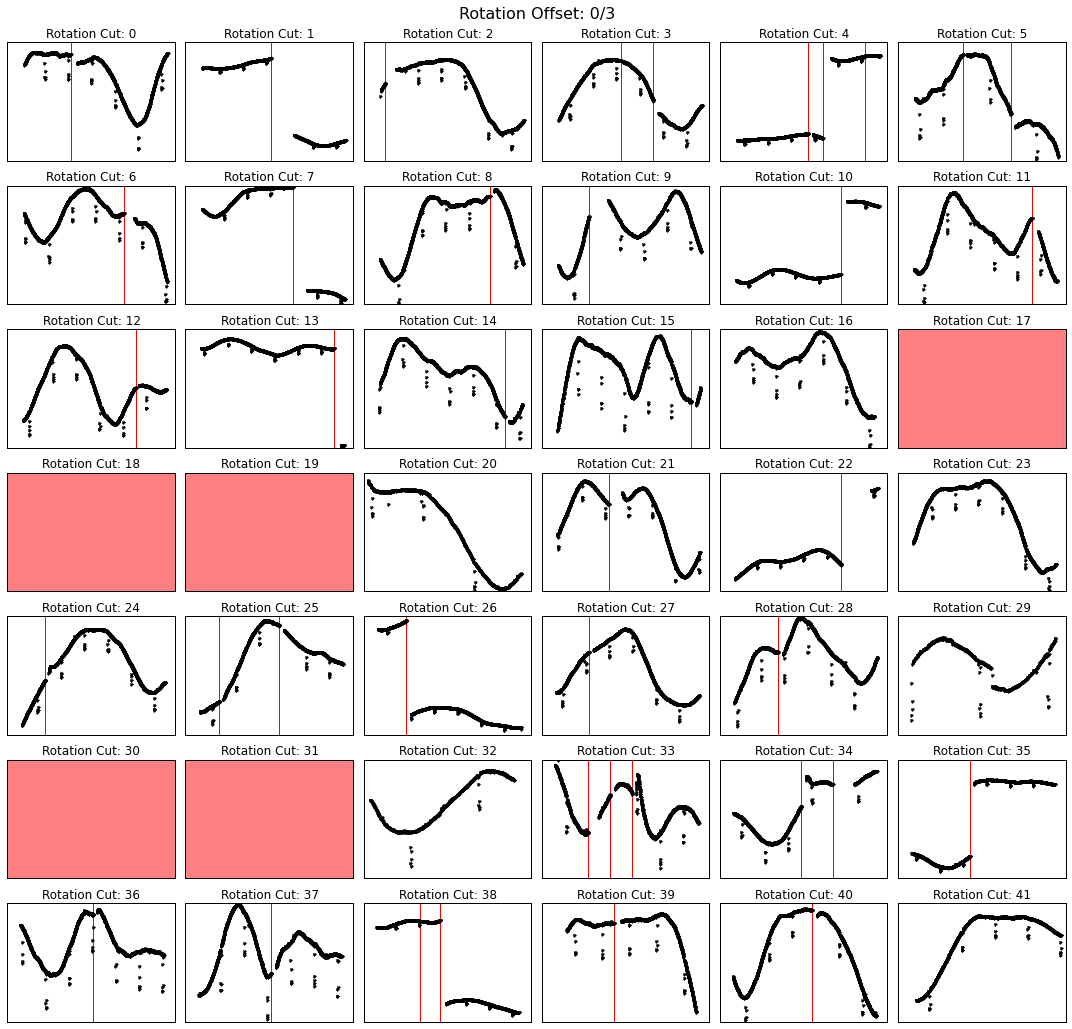

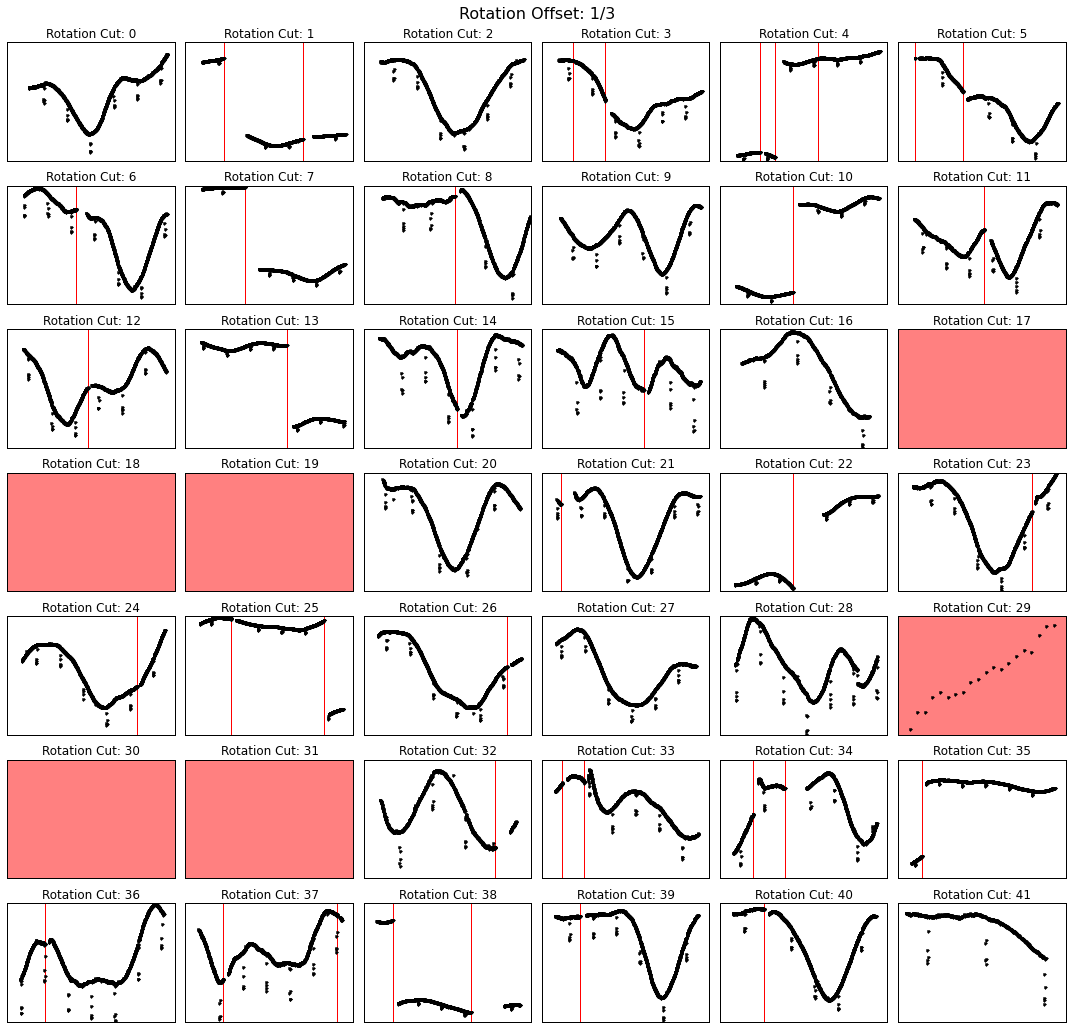

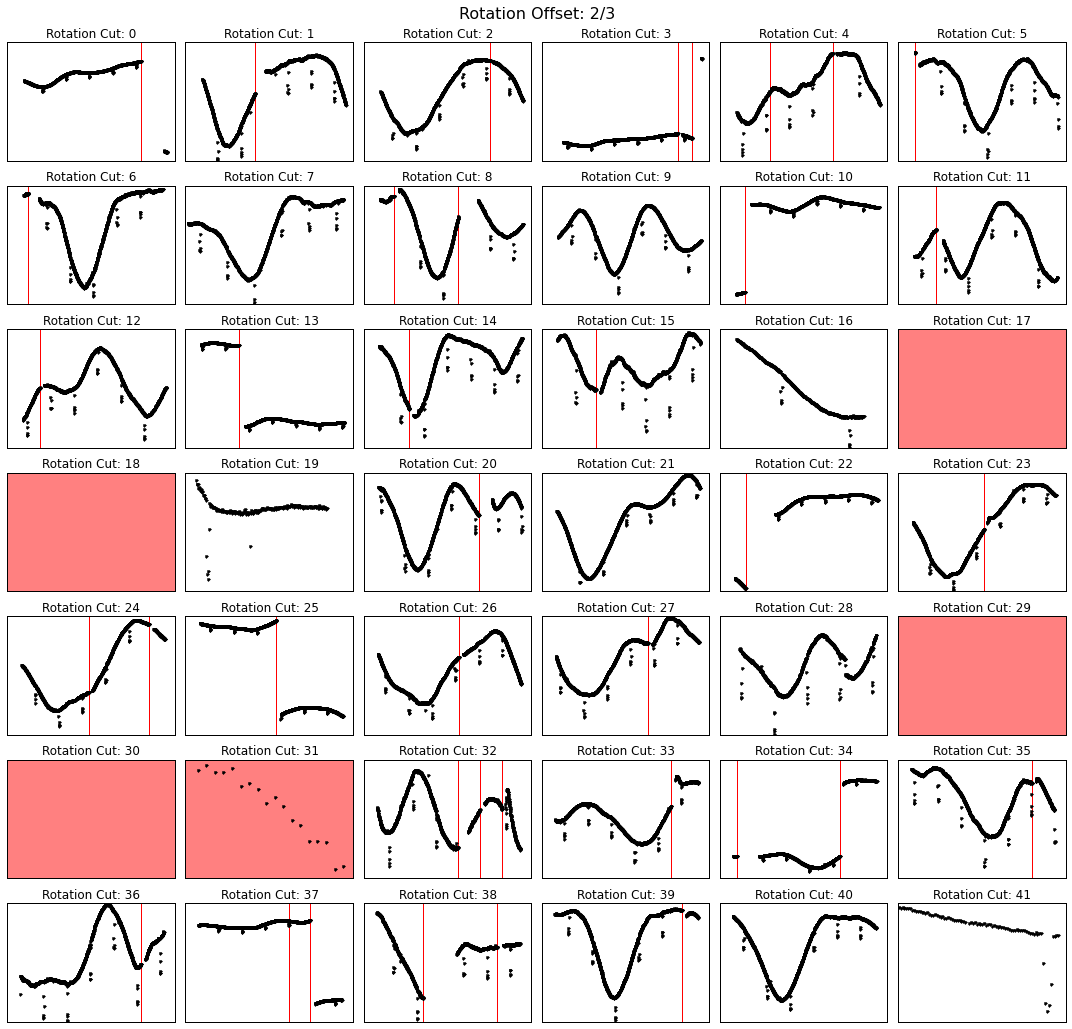

In [79]:
rotation_period = np.loadtxt('../params/stellar_rotation_period.txt').item()

# Move over window 1/3 of a rotation

for rotation_overlap_interval in range(3):

    rotations = ((long_lc.times.jd - long_lc.times.jd[0]) / rotation_period - 
                 rotation_overlap_interval/3.)
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(7, 6)
    axes = [plt.subplot(gs_axis) for gs_axis in gs]

    for i in range(42):#range(len(set(rotations.astype(int)))):
        this_rotation = (i < rotations) & (rotations < i+1)

        transit_model = generate_fiducial_model_lc_short(long_lc.times.jd[this_rotation],
                                                         2454605.89167, 0.00348, 0.1029, 0.295)
        transits_in_chunk = (transit_model != 1).any()
        
        sorted_times = np.sort(long_lc.times.jd[this_rotation])
        dt = np.diff(sorted_times)
        jump_inds = np.argwhere(dt > 2./24)#10*np.nanmedian(dt))
        jump_times = sorted_times[jump_inds]

        if len(jump_times) > 0:
            for jump_time in jump_times:
                axes[i].axvline(jump_time, color='r') 

        axes[i].plot(long_lc.times.jd[this_rotation], 
                     long_lc.fluxes[this_rotation], 'k.')
        axes[i].set(yticks=[], xticks=[], 
                    title='Rotation Cut: {0}'.format(i), 
                    axis_bgcolor='w' if transits_in_chunk else '#FF8080')
        
    gs.tight_layout(fig, rect=[0, 0.03, 1, 0.97])
    fig.suptitle('Rotation Offset: {0}/3'
                 .format(rotation_overlap_interval),
                 fontsize=16)
    plt.show()
    print('\n\n')

# Chunking by data gaps

72


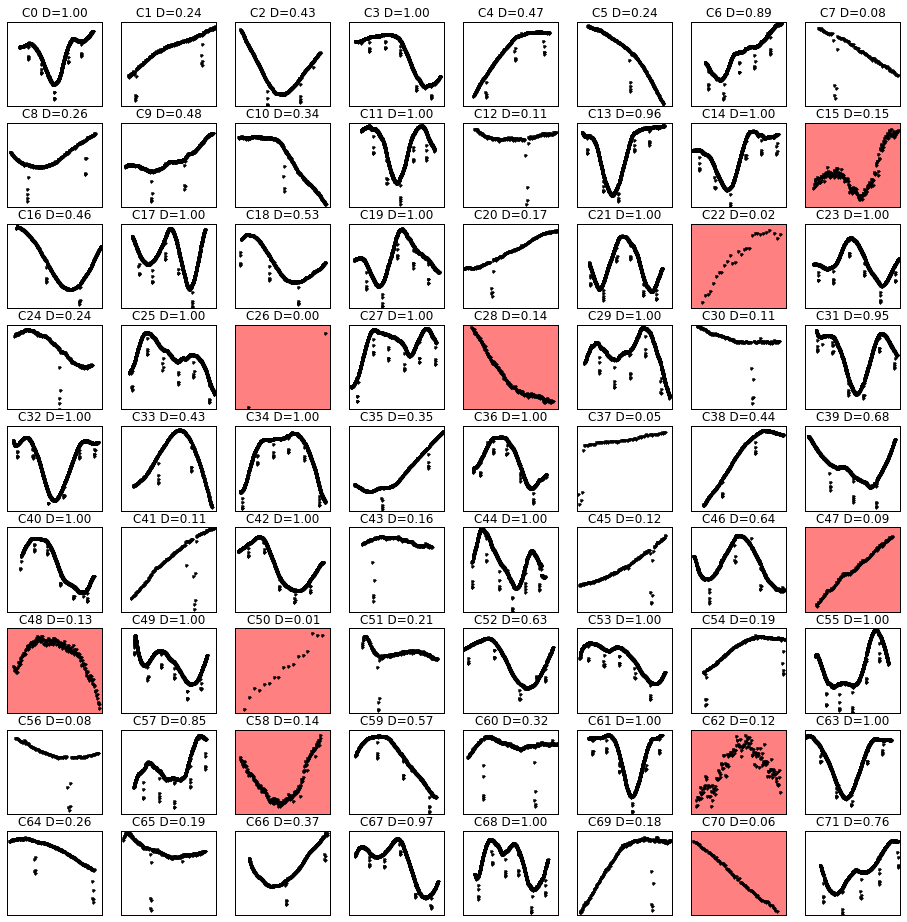

In [164]:
sorted_times = np.sort(long_lc.times.jd)
dt = np.diff(sorted_times)
jump_inds = np.argwhere(dt > 2./24)
jump_times = sorted_times[jump_inds]

chunk_masks = [(long_lc.times.jd > jump_times[i]) & 
               (long_lc.times.jd < jump_times[i+1])
               for i in range(len(jump_inds) -1)]

def break_up_into_rotations(chunk_masks, n_rotation_factor = 0.9):
    chunk_masks_limited = chunk_masks[:]
    
    n_indices_added = 0
    for j, chunk in enumerate(chunk_masks):
        t = long_lc.times.jd[chunk]
        
        if len(t) > 1 and t.max() - t.min() > n_rotation_factor*rotation_period: 
            chunk_masks_limited.pop(j+n_indices_added)

            subchunk1 = ((long_lc.times.jd >= t.min()) & 
                         (long_lc.times.jd <= t.min() + n_rotation_factor*rotation_period))
            subchunk2 = ((long_lc.times.jd >= t.min() + n_rotation_factor*rotation_period) & 
                         (long_lc.times.jd <= t.max()))

            t_subchunk2 = long_lc.times.jd[subchunk2]
            #assert t_subchunk2.max() - t_subchunk2.min() < rotation_period

            chunk_masks_limited.insert(j+n_indices_added, subchunk1)
            chunk_masks_limited.insert(j+n_indices_added+1, subchunk2)
            n_indices_added += 1
            
    return chunk_masks_limited

def break_up_into_rotations_recurse(chunk_masks, n_rotation_factor=0.9, 
                                    recursion_depth=5):
    chunk_masks_limited = break_up_into_rotations(chunk_masks, 
                                                  n_rotation_factor)
    for i in range(recursion_depth - 1):
        chunk_masks_limited = break_up_into_rotations(chunk_masks_limited, 
                                                      n_rotation_factor)
    return chunk_masks_limited

chunk_masks_limited = break_up_into_rotations_recurse(chunk_masks)

print(len(chunk_masks_limited))

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(9, 8)
axes = [plt.subplot(gs_axis) for gs_axis in gs]

#fig_wlc, ax_wlc = plt.subplots()

chunk_has_transits = []
light_curve_chunks = []

for i, chunk in enumerate(chunk_masks_limited):
    transit_model = generate_fiducial_model_lc_short(long_lc.times.jd[chunk],
                                                     2454605.89167, 0.00348, 
                                                     0.1029, 0.295)
    transits_in_chunk = (transit_model != 1).any()
    chunk_duration = long_lc.times.jd[chunk].max() - long_lc.times.jd[chunk].min()
    rotation_fraction = chunk_duration / (n_rotation_factor*rotation_period)
    chunk_has_transits.append(transits_in_chunk)
    if transits_in_chunk:
        light_curve_chunks.append(LightCurve(times=long_lc.times.jd[chunk], 
                                             fluxes=long_lc.fluxes[chunk],
                                             errors=long_lc.errors[chunk],
                                             quarters=long_lc.quarters[chunk]))    
    
    assert rotation_fraction <= 1, "Chunk {0} too long".format(i)
    
    axes[i].plot(long_lc.times.jd[chunk], 
                 long_lc.fluxes[chunk], 'k.')
    axes[i].set(yticks=[], xticks=[], 
                title='C{0} D={1:.2f}'.format(i, rotation_fraction), 
                axis_bgcolor='w' if transits_in_chunk else '#FF8080')
    
#    ax_wlc.plot(long_lc.times.jd[chunk], 
#                 long_lc.fluxes[chunk], 'k.')
plt.show()